In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import numpy
import torch.utils.data
from sklearn.model_selection import train_test_split

# Display Dataset

In [2]:
import sys
sys.path.append('..')

from Datasets.MackeyGlassDataset import MackeyGlassDataset
Mglass1 = MackeyGlassDataset(1000, 5, tau=17, seed=0)
Mglass2 = MackeyGlassDataset(10000, 2, tau=20, seed=0)

([<matplotlib.lines.Line2D at 0x280d29cb7d0>], (4995, 1))

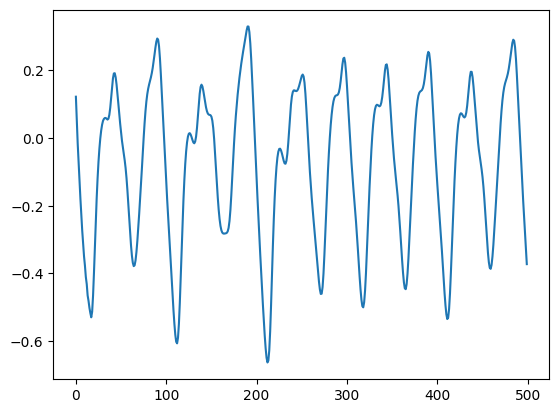

In [3]:
dataset = torch.utils.data.DataLoader(Mglass1, batch_size=1, shuffle=False)
dataset = np.array([data[0] for data in dataset]).reshape(-1, 1)
# loop through the input data (data[0]) and convert it to numpy array with shape of colomn vector

plt.plot(dataset[:500]), dataset.shape

### Splits of dataset

In [4]:
train_test_ratio = 0.8
train_size = int(len(dataset) * train_test_ratio)
test_size = len(dataset) - train_size

train_data, test_data = train_test_split(dataset, train_size=train_size, test_size=test_size)

train_data.shape, test_data.shape

((3996, 1), (999, 1))

In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU not available')


GPU is available


In [6]:
#train_data = torch.tensor(np.array([data[0] for data in train_dataset]).reshape(-1, 1)).to(device)
#test_data = torch.tensor(np.array([data[0] for data in test_dataset]).reshape(-1, 1)).to(device)
#train_data

# ESN 

In [7]:
from Models.Echostate import ESN

esn = ESN(input_dim = 1, reservoir_dim = 200, output_dim = 1)
esn.to(device)
esn.freeze_reservoir()  # Freeze reservoir weights

# Define optimizer and criterion for the readout layer
optimizer = torch.optim.Adam(esn.readout.parameters(), lr=0.05)
criterion = nn.MSELoss()

In [8]:
inputs, targets = Mglass1[0]

inputs = inputs.to(device) 
targets = targets.to(device)

for name, param in esn.named_parameters():
    print(f"{name} is on {param.device}")

print(inputs.device, targets.device)


readout.weight is on cuda:0
readout.bias is on cuda:0
cuda:0 cuda:0


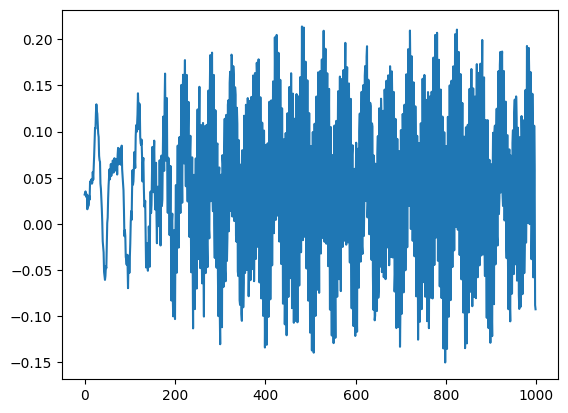

In [9]:
plt.plot(esn(inputs[:]).detach().cpu().numpy(), label='Prediction')

In [10]:
# Train the ESN model
#esn.Train(inputs, targets, epochs=50, lr=0.001, print_every=10)

In [11]:
## %%script false --no-raise-error

epochs = 100
losses = torch.tensor([]).to(device)  # Initialize loss tensor
outputs = torch.rand(len(inputs), 1).to(device)  # Initialize outputs tensor
outputs.device
outputs = outputs.to(device)  # Ensure inputs are on the same device as the model
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = esn(inputs)  # Forward pass
    loss = criterion(outputs, targets)  # Compute loss
    loss.backward()  # Backpropagate
    optimizer.step()  # Update only the readout layer
    losses = torch.cat((losses, torch.tensor([loss.item()]).to(device)), dim=0)  # Store loss
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    if epoch == epochs - 1:
        print(f"Final loss: {loss.item()}")

Epoch 1, Loss: 0.08250775188207626
Epoch 21, Loss: 0.019935667514801025
Epoch 41, Loss: 0.003088377881795168
Epoch 61, Loss: 0.0007738194544799626
Epoch 81, Loss: 0.0005302786594256759
Final loss: 0.00042786833364516497


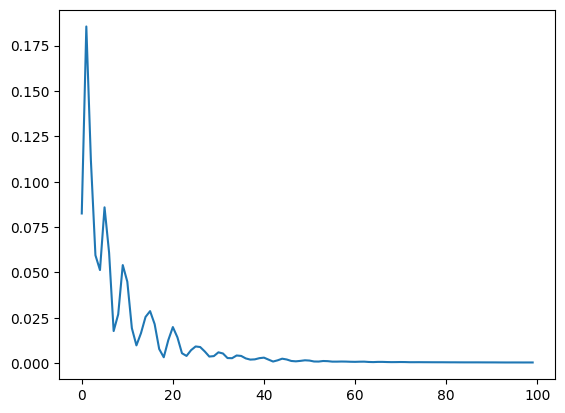

In [12]:
plt.plot(losses.cpu().detach().numpy())

In [15]:
Reservoir_states = esn.__get_reservoir_states__()
Readout = esn.__get_readout__()
Reservoir_state = esn.__get_reservoir_state__()
Reservoir_states.size(), Reservoir_state.size(), Readout

(torch.Size([999, 200]),
 torch.Size([200]),
 Linear(in_features=200, out_features=1, bias=True))

In [14]:
esn.Predict()

TypeError: ESN.Predict() missing 3 required positional arguments: 'readout', 'x_last', and 'steps'

In [12]:
%%script false --no-raise-error

test_data = torch.tensor(test_data).to(device)
test_output = []  # To store all predictions

# First prediction (using initial test data)
current_input = test_data[0].unsqueeze(0)  # The first data point as input to the ESN
test_output.append(esn(current_input))  # Get the first prediction

# Now use the last prediction to get the next one
for i in range(1, 30):
    # Get the last output, remove any extra dimensions, and reshape it if necessary
    current_input = test_output[i-1].unsqueeze(0)  # Get the last prediction as input for the next step
    #current_input = current_input.view(1, -1)  # Flatten it if necessary (if the ESN needs a 1D vector)
    next_output = esn(current_input)  # Generate the next prediction
    test_output.append(next_output)  # Append it to the output list

# Convert test_output back to a tensor if necessary
#test_output = torch.cat(test_output, dim=0)

Couldn't find program: 'false'


In [ ]:
test_data = torch.tensor(test_data).to(device)
test_output = []  # To store all predictions

# First prediction (using initial test data)
current_input = test_data[0].unsqueeze(0)  # The first data point as input to the ESN
test_output.append(esn(current_input))  # Get the first prediction

current_input, test_output

(tensor([[0.1672]], device='cuda:0'),
 [tensor([[0.1964]], device='cuda:0', grad_fn=<StackBackward0>)])

In [14]:
%%script false --no-raise-error

test_data = torch.tensor(test_data).to(device)
test_output = outputs[-1:].to(device)

for i in range(len(test_data)):
    if i == 0:
        test_output = esn(temp[i].unsqueeze(0))
    else:
        test_output = torch.cat((test_output, esn(test_output[i-1].unsqueeze(0))), dim=0)

test_output

Couldn't find program: 'false'


In [ ]:
test_data = test_data
test_output = test_output
plt.figure(figsize=(10, 5))
plt.plot(test_data.numpy(), label='True Data')
plt.plot(test_output.detach().numpy(), label='Predictions')
plt.legend()
plt.title('Predictions vs True Data')
plt.xlabel('Time Steps')
plt.ylabel('Values')

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

<Figure size 1000x500 with 0 Axes>